In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 26 2024

@author: Yaning
Suggested by Sarah
"""
# functions for simulating agent data
# this file address is your own
%run Documents/pyro_models/multi_agent_simulation.py

import math
import os
# from turtle import position
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform, Bernoulli, Categorical, Gamma
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
# import pandas as pd
import numpy as np
import scipy.stats as stats 


['', 'trial', 'val_basic', 'delay', 'val_prc', 'response', 'RT', 'respSide', 'sideNOW', 'Version', 'loopID', 'Context']


In [4]:
# prior mean 0
# prior variance 3
# estimation variance (uncertainty) .5 but change with delay
mean_u_list = [torch.tensor(3.)]
sigma_u_list = [torch.tensor(6.)]
sigma_es_list = [torch.tensor(3.)]
beta_list = [torch.tensor(0.8)]

# initialise trial combinations
repetition = 10
real_delays = [1., 3., 7., 13., 24., 32., 45., 58., 75., 122.]
delays =  [i / 10 for i in real_delays]
SS_values = [5.]
# LL values by percentage of SS
LL_values_p = [1.05, 1.055, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.85, 1.9, 2.05, 2.25, 2.55, 2.85, 3.05, 3.45, 3.85]

In [6]:
environment = Environment(SS_values, LL_values_p, delays, repetition)
# run function returns first parameter list then inference list
parameters_list, inference_list = run(mean_u_list, sigma_u_list, sigma_es_list, beta_list, environment)

In [7]:
inference_list

array([[[[[[[ 1.  ,  0.  ,  0.  , ...,  1.  ,  1.  ,  1.  ],
            [ 0.1 ,  0.1 ,  0.1 , ..., 12.2 , 12.2 , 12.2 ],
            [ 5.  ,  5.  ,  5.  , ...,  5.  ,  5.  ,  5.  ],
            [ 5.25,  5.25,  5.25, ..., 19.25, 19.25, 19.25]]]]]]])

Use log all normal distributions.

In [14]:
# SVI model
# simulate parameters:
# mean_u 0
# sigma_u 6
# sigma_es 3

def model_normal_log(actions, delays, ss_values, ll_values):
    
    mean_u_mean_q = pyro.param("mean_u_mean_q", torch.tensor(0.))
    mean_u_sigma_q = pyro.param("mean_u_sigma_q", torch.tensor(1.))
    sigma_u_mean_q =  pyro.param("sigma_u_mean_q", torch.tensor(1.))
    sigma_u_sigma_q =  pyro.param("sigma_u_sigma_q", torch.tensor(2.))
    sigma_es_mean_q = pyro.param("sigma_es_mean_q", torch.tensor(1.))
    sigma_es_sigma_q = pyro.param("sigma_es_sigma_q", torch.tensor(2.))
    beta_mean_q = pyro.param("beta_mean_q", torch.tensor(1.))
    beta_sigma_q = pyro.param("beta_sigma_q", torch.tensor(2.))

    # sample from the HalfCauchy prior and normal distributions
    mean_u = pyro.sample("mean_u", Normal(loc=mean_u_mean_q, scale=mean_u_sigma_q))
    log_sigma_u = pyro.sample("log_sigma_u", Normal(loc=sigma_u_mean_q, scale = sigma_u_sigma_q))
    log_sigma_es = pyro.sample("log_sigma_es", Normal(loc=sigma_es_mean_q, scale = sigma_es_sigma_q))
    # beta sample from distribution mean is always 1.0 
    beta = pyro.sample("beta", Normal(loc=beta_mean_q, scale = beta_sigma_q))
    # loop over the observed data
    e_vals = []
    v_vals = []
    for i in range(len(actions)):
        sigma_u = torch.exp(log_sigma_u)
        sigma_es = torch.exp(log_sigma_es)
        e_vals.append((mean_u*delays[i]*sigma_es**2 + ll_values[i]*sigma_u**2)/
                      (delays[i]*sigma_es**2 + sigma_u**2))
        softmax_args = torch.stack([beta*e_vals[-1], beta*ss_values[i]])
        p = torch.softmax(softmax_args, dim = 0)[0]
        pyro.sample("obs_" + str(i), Bernoulli(probs = p), obs=actions[i])

def guide_normal_log(actions, delays, ss_values, ll_values):
    # get rid of the constrains
    mean_u_mean_q = pyro.param("mean_u_mean_q", torch.tensor(0.))
    mean_u_sigma_q = pyro.param("mean_u_sigma_q", torch.tensor(1.), 
                                constraint=constraints.positive)
    sigma_u_mean_q = pyro.param("sigma_u_mean_q", torch.tensor(2.))
    sigma_u_sigma_q = pyro.param("sigma_u_sigma_q", torch.tensor(1.),
                                 constraint=constraints.positive)
    sigma_es_mean_q = pyro.param("sigma_es_mean_q", torch.tensor(1.))
    sigma_es_sigma_q = pyro.param("sigma_es_sigma_q", torch.tensor(2.),
                                  constraint=constraints.positive)
    beta_mean_q = pyro.param("beta_mean_q", torch.tensor(1.))
    beta_sigma_q = pyro.param("beta_sigma_q", torch.tensor(2.), 
                              constraint=constraints.positive)

    # sample from the HalfCauchy prior and normal distributions
    mean_u = pyro.sample("mean_u", Normal(loc=mean_u_mean_q, scale=mean_u_sigma_q))
    log_sigma_u = pyro.sample("log_sigma_u", Normal(sigma_u_mean_q, sigma_u_sigma_q))
    log_sigma_es = pyro.sample("log_sigma_es", Normal(sigma_es_mean_q, sigma_es_sigma_q))
    beta = pyro.sample("beta", Normal(loc=beta_mean_q, scale = beta_sigma_q))



#model(actions, delays, ss_values, ll_values)
# pyro.render_model(model=model, model_args=(actions, delays, ss_values, ll_values,),render_params=True, render_distributions=True,filename="model.pdf")
auto_g_normal_log = pyro.infer.autoguide.AutoMultivariateNormal(model_normal_log)
# pyro.render_model(model=guide, model_args=(actions, delays, ss_values, ll_values,),render_params=True, render_distributions=True,filename="guide.pdf")


Use Gamma distributions for the sigmas.

In [11]:
# SVI model
# simulate parameters:
# mean_u 0
# sigma_u 6
# sigma_es 3

def model_gamma(actions, delays, ss_values, ll_values):
    
    mean_u_mean_q = pyro.param("mean_u_mean_q", torch.tensor(0.))
    mean_u_sigma_q = pyro.param("mean_u_sigma_q", torch.tensor(1.), 
                                constraint=constraints.positive)
    sigma_u_alpha_q = pyro.param("sigma_u_alpha_q", torch.tensor(1.), 
                                 constraint=constraints.positive)
    sigma_u_beta_q = pyro.param("sigma_u_beta_q",  torch.tensor(2.),
                                constraint=constraints.positive)
    sigma_es_alpha_q = pyro.param("sigma_es_alpha_q", torch.tensor(1.), 
                                  constraint=constraints.positive)
    sigma_es_beta_q = pyro.param("sigma_es_beta_q", torch.tensor(2.), 
                                 constraint=constraints.positive)

    # sample from the HalfCauchy prior and normal distributions
    mean_u = pyro.sample("mean_u", Normal(loc=mean_u_mean_q, scale=mean_u_sigma_q))
    sigma_u = pyro.sample("sigma_u", Gamma(sigma_u_alpha_q, sigma_u_beta_q))
    sigma_es = pyro.sample("sigma_es", Gamma(sigma_es_alpha_q, sigma_es_beta_q))
    # loop over the observed data
    e_vals = []
    v_vals = []
    for i in range(len(actions)):
        e_vals.append((mean_u*delays[i]*sigma_es**2 + ll_values[i]*sigma_u**2)/
                      (delays[i]*sigma_es**2 + sigma_u**2))
        softmax_args = torch.stack([e_vals[-1], ss_values[i]])
        p = torch.softmax(softmax_args, dim = 0)[0]
        pyro.sample("obs_" + str(i), Bernoulli(probs = p), obs=actions[i])

def guide_gamma(actions, delays, ss_values, ll_values):
    # get rid of the constrains
    mean_u_mean_q = pyro.param("mean_u_mean_q", torch.tensor(0.))
    mean_u_sigma_q = pyro.param("mean_u_sigma_q", torch.tensor(1.), 
                              constraint=constraints.positive)
    sigma_u_alpha_q = pyro.param("sigma_u_alpha_q", torch.tensor(2.), 
                                constraint=constraints.positive)
    sigma_u_beta_q = pyro.param("sigma_u_beta_q", torch.tensor(1.), 
                               constraint=constraints.positive)
    sigma_es_alpha_q = pyro.param("sigma_es_alpha_q", torch.tensor(1.), 
                                  constraint=constraints.positive)
    sigma_es_beta_q = pyro.param("sigma_es_beta_q", torch.tensor(2.), 
                                 constraint=constraints.positive)

    # sample from the HalfCauchy prior and normal distributions
    mean_u = pyro.sample("mean_u", Normal(loc=mean_u_mean_q, scale=mean_u_sigma_q))
    sigma_u = pyro.sample("sigma_u", Gamma(sigma_u_alpha_q, sigma_u_beta_q))
    sigma_es = pyro.sample("sigma_es", Gamma(sigma_es_alpha_q, sigma_es_beta_q))

#model(actions, delays, ss_values, ll_values)
# pyro.render_model(model=model, model_args=(actions, delays, ss_values, ll_values,),render_params=True, render_distributions=True,filename="model.pdf")
auto_g_gamma = pyro.infer.autoguide.AutoMultivariateNormal(model_gamma)
# pyro.render_model(model=guide, model_args=(actions, delays, ss_values, ll_values,),render_params=True, render_distributions=True,filename="guide.pdf")


In [6]:
for i in inference_list:
    for j in i:
        for k in j:
            actions = torch.tensor(k[0])
            delays = torch.tensor(k[1])
            ss_values = torch.tensor(k[2])
            ll_values = torch.tensor(k[3])
            print(delays)

tensor([ 0.1000,  0.1000,  0.1000,  ..., 12.2000, 12.2000, 12.2000],
       dtype=torch.float64)


Mean ELBO  56.65: 100%|███████████████████████████████████████████| 400/400 [00:23<00:00, 16.87it/s]


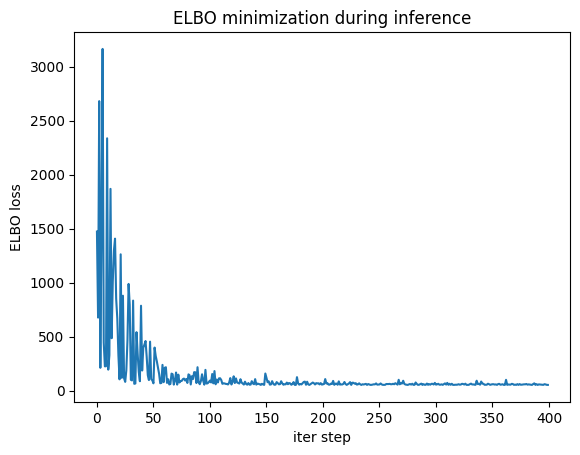

In [23]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
# the step was 2000
n_steps = 2 if smoke_test else 400

# assert pyro.__version__.startswith('1.8.6')

# clear the param store in case we're in a REPL
pyro.clear_param_store()# setup the optimizer
# the learning rate was 0.0005 , "betas": (0.90, 0.999)
# tried "n_par":15 in adam params but it does not have this argument
adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)
# setup the inference algorithm
svi = SVI(model_normal_log, guide_normal_log, optimizer, loss=Trace_ELBO())
# svi = SVI(model_gamma, guide_gamma, optimizer, loss=Trace_ELBO())

loss = []
pbar = tqdm(range(n_steps), position = 0)
# do gradient steps
for step in pbar:
    loss.append(torch.tensor(svi.step(actions, delays, ss_values, ll_values)))
    pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
    # for name, value in pyro.get_param_store().items():
    #     print(name, pyro.param(name))
    if torch.isnan(loss[-1]):
	    break

plt.figure()
plt.plot(loss)
plt.xlabel("iter step")
plt.ylabel("ELBO loss")
plt.title("ELBO minimization during inference")
plt.show()

In [24]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

mean_u_mean_q tensor(2.0369, requires_grad=True)
mean_u_sigma_q tensor(0.4781, grad_fn=<AddBackward0>)
sigma_u_mean_q tensor(1.7491, requires_grad=True)
sigma_u_sigma_q tensor(0.0522, grad_fn=<AddBackward0>)
sigma_es_mean_q tensor(1.2509, requires_grad=True)
sigma_es_sigma_q tensor(0.0764, grad_fn=<AddBackward0>)
beta_mean_q tensor(0.3072, requires_grad=True)
beta_sigma_q tensor(0.0855, grad_fn=<AddBackward0>)


In [17]:
intermedia_params

{}

In [ ]:
# only used for auto guide
# auto guide does not work too well in this model
n_samples = 1000
post_mean_u = []
post_sigma_u = []
post_sigma_es = []
for i in range(n_samples):
    sample = auto_g_normal_log()
    # print(sample)
    post_mean_u.append(sample["mean_u"].detach().item())
    post_sigma_u.append(sample["log_sigma_u"].detach().item())
    post_sigma_es.append(sample["log_sigma_es"].detach().item())